<a href="https://colab.research.google.com/github/virf96/Imbalanced/blob/main/M%C3%A9tricas_Geometric_Mean_Dominance_IBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Geometric Mean, Dominance, Index of Imbalanced Accuracy

- **G-Mean** = sqrt( tp / (tp = fn) * tn / (tn + fp) ) = sqrt ( recall x True Negative Rate)

- **Dominance** = True Positive Rate - True Negative Rate

- **IBA** = M * (1 + alpha * Dominance)

- **TPR** = **Recall** = tp / (tp + fn)

- **TNR** = tn / (tn + fp)


All of these metrics depend on the discrimination threshold used to classify an observation as member of the minority or positive class.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    recall_score,
    accuracy_score,
    balanced_accuracy_score,
)

from imblearn.metrics import (
    geometric_mean_score,
    make_index_balanced_accuracy,
)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

## Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load data
data = pd.read_csv('/content/drive/MyDrive/datasets/kdd2004.csv')

# remap target class to 0 and 1
data['target'] = data['target'].map({-1:0, 1:1})

data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,target
0,52.0,32.69,0.30,2.5,20.0,1256.8,-0.89,0.33,11.0,-55.0,267.2,0.52,0.05,-2.36,49.6,252.0,0.43,1.16,-2.06,-33.0,-123.2,1.60,-0.49,-6.06,65.0,296.1,-0.28,-0.26,-3.83,-22.6,-170.0,3.06,-1.05,-3.29,22.9,286.3,0.12,2.58,4.08,-33.0,-178.9,1.88,0.53,-7.0,-44.0,1987.0,-5.41,0.95,-4.0,-57.0,722.9,-3.26,-0.55,-7.5,125.5,1547.2,-0.36,1.12,9.0,-37.0,72.5,0.47,0.74,-11.0,-8.0,1595.1,-1.64,2.83,-2.0,-50.0,445.2,-0.35,0.26,0.76,0
1,58.0,33.33,0.00,16.5,9.5,608.1,0.50,0.07,20.5,-52.5,521.6,-1.08,0.58,-0.02,-3.2,103.6,-0.95,0.23,-2.87,-25.9,-52.2,-0.21,0.87,-1.81,10.4,62.0,-0.28,-0.04,1.48,-17.6,-198.3,3.43,2.84,5.87,-16.9,72.6,-0.31,2.79,2.71,-33.5,-11.6,-1.11,4.01,5.0,-57.0,666.3,1.13,4.38,5.0,-64.0,39.3,1.07,-0.16,32.5,100.0,1893.7,-2.80,-0.22,2.5,-28.5,45.0,0.58,0.41,-19.0,-6.0,762.9,0.29,0.82,-3.0,-35.0,140.3,1.16,0.39,0.73,0
2,77.0,27.27,-0.91,6.0,58.5,1623.6,-1.40,0.02,-6.5,-48.0,621.0,-1.20,0.14,-0.20,73.6,609.1,-0.44,-0.58,-0.04,-23.0,-27.4,-0.72,-1.04,-1.09,91.1,635.6,-0.88,0.24,0.59,-18.7,-7.2,-0.60,-2.82,-0.71,52.4,504.1,0.89,-0.67,-9.30,-20.8,-25.7,-0.77,-0.85,0.0,-20.0,2259.0,-0.94,1.15,-4.0,-44.0,-22.7,0.94,-0.98,-19.0,105.0,1267.9,1.03,1.27,11.0,-39.5,82.3,0.47,-0.19,-10.0,7.0,1491.8,0.32,-1.29,0.0,-34.0,658.2,-0.76,0.26,0.24,0
3,41.0,27.91,-0.35,3.0,46.0,1921.6,-1.36,-0.47,-32.0,-51.5,560.9,-0.29,-0.10,-1.11,124.3,791.6,0.00,0.39,-1.85,-21.7,-44.9,-0.21,0.02,0.89,133.9,797.8,-0.08,1.06,-0.26,-16.4,-74.1,0.97,-0.80,-0.41,66.9,955.3,-1.90,1.28,-6.65,-28.1,47.5,-1.91,1.42,1.0,-30.0,1846.7,0.76,1.10,-4.0,-52.0,-53.9,1.71,-0.22,-12.0,97.5,1969.8,-1.70,0.16,-1.0,-32.5,255.9,-0.46,1.57,10.0,6.0,2047.7,-0.98,1.53,0.0,-49.0,554.2,-0.83,0.39,0.73,0
4,50.0,28.00,-1.32,-9.0,12.0,464.8,0.88,0.19,8.0,-51.5,98.1,1.09,-0.33,-2.16,-3.9,102.7,0.39,-1.22,-3.39,-15.2,-42.2,-1.18,-1.11,-3.55,8.9,141.3,-0.16,-0.43,-4.15,-12.9,-13.4,-1.32,-0.98,-3.69,8.8,136.1,-0.30,4.13,1.89,-13.0,-18.7,-1.37,-0.93,0.0,-1.0,810.1,-2.29,6.72,1.0,-23.0,-29.7,0.58,-1.10,-18.5,33.5,206.8,1.84,-0.13,4.0,-29.0,30.1,0.80,-0.24,5.0,-14.0,479.5,0.68,-0.59,2.0,-36.0,-6.9,2.02,0.14,-0.23,0


In [4]:
# data size

data.shape

(145751, 75)

In [5]:
# imbalanced target

data.target.value_counts() / len(data)

0    0.991108
1    0.008892
Name: target, dtype: float64

In [6]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((102025, 74), (43726, 74))

## Baseline: predict the majority class

In [8]:
# Baseline prediction: predict the majority class
#Creamos un vector de ceros para ejemplicar casos para las métricas

y_train_base = pd.Series(np.zeros(len(y_train)))
y_test_base = pd.Series(np.zeros(len(y_test)))

## Train ML models

### Random Forests

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=2, n_jobs=4)

rf.fit(X_train, y_train)

y_train_rf = rf.predict_proba(X_train)[:,1]
y_test_rf = rf.predict_proba(X_test)[:,1]

### Logistic Regression

In [10]:
logit = LogisticRegression(random_state=0,  max_iter=1000)

logit.fit(X_train, y_train)

y_train_logit = logit.predict_proba(X_train)[:,1]
y_test_logit = logit.predict_proba(X_test)[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Recall

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

- **TPR** = **Recall** = tp / (tp + fn)

In [11]:
print('Recall Baseline test: ', recall_score(y_test, y_test_base, pos_label=1))
print('Recall Random Forest test:', recall_score(y_test, rf.predict(X_test), pos_label=1))
print('Recall Logistic Regression test:', recall_score(y_test, logit.predict(X_test), pos_label=1))

Recall Baseline test:  0.0
Recall Random Forest test: 0.6024691358024692
Recall Logistic Regression test: 0.7234567901234568


Observamos que la tasa de verdadero positivos es de 0% para el primer caso dado que el modelo unicamente predice para una clase.

## True Negative Rate

Equivalent of Recall, but for the majority class.

- **TNR** = tn / (tn + fp)

In [12]:
print('TNR Baseline test: ', recall_score(y_test, y_test_base, pos_label=0))
print('TNR Random Forest test:', recall_score(y_test, rf.predict(X_test), pos_label=0))
print('TNR Logistic Regression test:', recall_score(y_test, logit.predict(X_test), pos_label=0))

TNR Baseline test:  1.0
TNR Random Forest test: 0.9999769165070058
TNR Logistic Regression test: 0.9995152466471227


Observamos que la tasa de verdadero positivos es de 100% para el primer caso dado que el modelo unicamente predice para una clase.

## Geometric Mean

https://imbalanced-learn.org/stable/generated/imblearn.metrics.geometric_mean_score.html

- **G-Mean** = sqrt( tp / (tp = fn) * tn / (tn + fp) ) = sqrt ( recall x True Negative Rate)

In [ ]:
print('G-Mean Baseline test: ', geometric_mean_score(y_test, y_test_base))
print('G-Mean Random Forest test:', geometric_mean_score(y_test, rf.predict(X_test)))
print('G-Mean Logistic Regression test:', geometric_mean_score(y_test, logit.predict(X_test)))

G-Mean Baseline test:  0.0
G-Mean Random Forest test: 0.7761798945543448
G-Mean Logistic Regression test: 0.8488942868371214


Observamos el mismo caso para el primer caso dado que esta métrica pondera que tan bien podemos clasificar ambas clases

## Dominance

- **Dominance** = True Positive Rate - True Negative Rate

In [13]:
def dominance(y_true, y_pred):
    tpr = recall_score(y_test, y_pred, pos_label=1)
    tnr = recall_score(y_test, y_pred, pos_label=0)
    return tpr - tnr

In [14]:
print('Dominance Baseline test: ', dominance(y_test, y_test_base))
print('Dominance Random Forest test:', dominance(y_test, rf.predict(X_test)))
print('Dominance Logistic Regression test:', dominance(y_test, logit.predict(X_test)))

Dominance Baseline test:  -1.0
Dominance Random Forest test: -0.39750778070453663
Dominance Logistic Regression test: -0.2760584565236659


Métrica que va de -1 a 1 

## Metrics vs threshold

Text(0.5, 1.0, 'Metrics vs Discriminant Threshold')

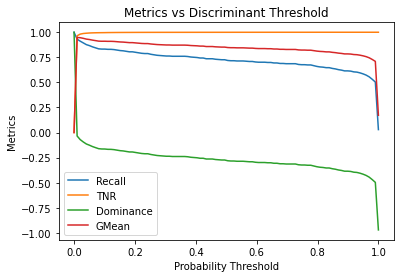

In [15]:
# list of thresholds
thresholds = np.linspace(0, 1, 100)

# list co collect values
recall_ls = []
tnr_ls = []
dominance_ls = []
gmean_ls = []

# obtain probabilities
probs_logit = logit.predict_proba(X_test)[:, 1]

# calculate G-Mean based on thresholds
for threshold in thresholds:

    # obtain class prediction based on threshold
    preds_logit = np.where(probs_logit >= threshold, 1, 0)

    # obtain metrics
    recall_ls.append(recall_score(y_test, preds_logit, pos_label=1))
    tnr_ls.append((recall_score(y_test, preds_logit, pos_label=0)))
    dominance_ls.append(dominance(y_test, preds_logit))
    gmean_ls.append(geometric_mean_score(y_test, preds_logit))


# after loop concatenate metrics
metrics = pd.concat([
    pd.Series(recall_ls),
    pd.Series(tnr_ls),
    pd.Series(dominance_ls),
    pd.Series(gmean_ls)], axis=1)

# add column names and thresholds in index
metrics.columns = ['Recall', 'TNR', 'Dominance', 'GMean']
metrics.index = thresholds

# plot
metrics.plot()
plt.xlabel('Probability Threshold')
plt.ylabel('Metrics')
plt.title('Metrics vs Discriminant Threshold')

Observamos como va cambiando el rendimiento de las métricas conforme vamos variando el punto de corte.

## Index of imbalanced accuracy

### Geometric Mean

In [16]:
print('G-Mean Baseline test: ', geometric_mean_score(y_test, y_test_base))
print('G-Mean Random Forest test:', geometric_mean_score(y_test, rf.predict(X_test)))
print('G-Mean Logistic Regression test:', geometric_mean_score(y_test, logit.predict(X_test)))

G-Mean Baseline test:  0.0
G-Mean Random Forest test: 0.7761798945543448
G-Mean Logistic Regression test: 0.8503564499777623


In [17]:
gmean = make_index_balanced_accuracy(alpha=0.5, squared=True)(geometric_mean_score)

print('Corrected G-Mean Baseline test: ', gmean(y_test, y_test_base))
print('Corrected G-Mean Random Forest test:', gmean(y_test, rf.predict(X_test)))
print('Corrected G-Mean Logistic Regression test:', gmean(y_test, logit.predict(X_test)))

Corrected G-Mean Baseline test:  0.0
Corrected G-Mean Random Forest test: 0.6024552287103938
Corrected G-Mean Logistic Regression test: 0.7231060920187825


### Accuracy

In [18]:
print('Accuracy Baseline test: ', accuracy_score(y_test, y_test_base))
print('Accuracy Random Forest test:', accuracy_score(y_test, rf.predict(X_test)))
print('Accuracy Logistic Regression test:', accuracy_score(y_test, logit.predict(X_test)))

Accuracy Baseline test:  0.9907377761514888
Accuracy Random Forest test: 0.9962951104605955
Accuracy Logistic Regression test: 0.996958331427526


In [19]:
acc = make_index_balanced_accuracy(alpha=0.5, squared=True)(accuracy_score)

print('Corrected Accuracy Baseline test: ', acc(y_test, y_test_base))
print('Corrected Accuracy Random Forest test:', acc(y_test, rf.predict(X_test)))
print('Corrected Accuracy Logistic Regression test:', acc(y_test, logit.predict(X_test)))

Corrected Accuracy Baseline test:  0.4907806705467988
Corrected Accuracy Random Forest test: 0.7953200510570445
Corrected Accuracy Logistic Regression test: 0.8567350876607018


## Balanced Accuracy

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html

In [20]:
print('Corrected Accuracy Baseline test: ', balanced_accuracy_score(y_test, y_test_base))
print('Corrected Accuracy Random Forest test:', balanced_accuracy_score(y_test, rf.predict(X_test)))
print('Corrected Accuracy Logistic Regression test:', balanced_accuracy_score(y_test, logit.predict(X_test)))

Corrected Accuracy Baseline test:  0.5
Corrected Accuracy Random Forest test: 0.8012230261547375
Corrected Accuracy Logistic Regression test: 0.8614860183852897


Accuracy ajustado mediante el parámetro alpha para cuando las clases están desbalanceadas